This notebook is about **TIME SERIES FORECAST**

*Predict Future Sales Dataset* will be used:
[https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data?select=sales_train.csv]

3 different methods will used to see which one suits better for this particular dataset:
* **Triple Exponential Smoothing (Holt-Winter's)**
* **Seasonal Auto Regressive Integrated Moving Average (SARIMA)**
* **Light GBM** 

In **T.E.S.** and **SARIMA** methods, *hyperparameter optimization* will be implemented. 

In **Light GBM**, both *feature engineering* and *hyperparameter optimization* methods will be used. 

For the part of choosing the right method, for simplicity, I will derive monthly total sales and evaluate the methods according to monthly sales forecasts using validation set approach. Years between 2013 and 2016 will be training set and year 2017 will be validation set. MAE will be used for comparing different methods. 

After choosing the method according to best MAE score, I will revise the model using the chosen method and implement it to test set to make forecasts. 

STEP 1: Exploratory Data Analysis
* a-Amount sold at each  store (Monthly)
* b-Amount sold for each item (Monthly)
* c-Outlier/Missing Value Analysis

STEP 2: Forecast sales using T.E.S.

* a-Rearranging the train set into train and validation
* b-Hyperparameter optimization
* c-Fit the model to validation dataset to see results

STEP 3: Forecast sales using SARIMAX

* a-Hyperparameter optimization
* b-Fit the model to validation dataset to see results

STEP 4: Forecast sales using Light GBM

* a-Feature enginnering
* b-Hyperparameter optimization
* c-Fit the model to validation dataset to see results

STEP 5: Forecast sales with daily values using the best method (Lowest MAE score)

* a-Feature enginnering
* b-Hyperparameter optimization
* c-Fit the model to validation dataset to see results

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import datetime as dt
train = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/train.csv")
test = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/test.csv")

In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(train)

##################### Shape #####################
(913000, 4)
##################### Types #####################
date     object
store     int64
item      int64
sales     int64
dtype: object
##################### Head #####################
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
##################### Tail #####################
              date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82
##################### NA #####################
date     0
store    0
item     0
sales    0
dtype: int64
##################### Quantiles #####################
       0.00  0.05  0.50   0.95   0.99   1.00
store   1.0   1.0   5.5   10.0   10.0   10.0
item    1.0   3.0  25.5   

In [4]:
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
train["year_month"] = train["date"].dt.to_period('M')
train["year_month"] = train["year_month"].astype(str)

In [5]:
df = train.groupby(["year_month", "store", "item"]).agg({"sales":"sum"})
df = df.reset_index()

In [6]:
df.head()

,year_month,store,item,sales
0,2013-01,1,1,328
1,2013-01,1,2,911
2,2013-01,1,3,547
3,2013-01,1,4,346
4,2013-01,1,5,276


In [7]:
df.tail()
df.info()

,year_month,store,item,sales
29995,2017-12,10,46,1723
29996,2017-12,10,47,626
29997,2017-12,10,48,1537
29998,2017-12,10,49,815
29999,2017-12,10,50,1987


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year_month  30000 non-null  object
 1   store       30000 non-null  int64 
 2   item        30000 non-null  int64 
 3   sales       30000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 937.6+ KB


In [8]:
df.groupby("store").agg({"sales":"sum"}).sort_values \
(by="sales", ascending=False).head()
df.groupby("store").agg({"sales":"sum"}).sort_values \
(by="sales").head()

,sales
store,
2,6120128
8,5856169
3,5435144
10,5360158
9,5025976


,sales
store,
7,3320009
6,3627670
5,3631016
1,4315603
4,5012639


In [9]:
df.groupby("item").agg({"sales":"sum"}).sort_values \
(by="sales", ascending=False).head()
df.groupby("item").agg({"sales":"sum"}).sort_values \
(by="sales").head()

,sales
item,
15,1607442
28,1604713
13,1539621
18,1538876
25,1473334


,sales
item,
5,335230
1,401384
41,401759
47,401781
4,401907


In [10]:
df.groupby("store").agg({"item":"count"}) #no missing values
df.groupby("store").agg({"sales":"sum"}).describe().T #no outlier for total 
#sales for stores. 

,item
store,
1,3000
2,3000
3,3000
4,3000
5,3000
6,3000
7,3000
8,3000
9,3000


,count,mean,std,min,25%,50%,75%,max
sales,10.0,4770451.2,990446.588081,3320009.0,3802162.75,5019307.5,5416397.5,6120128.0


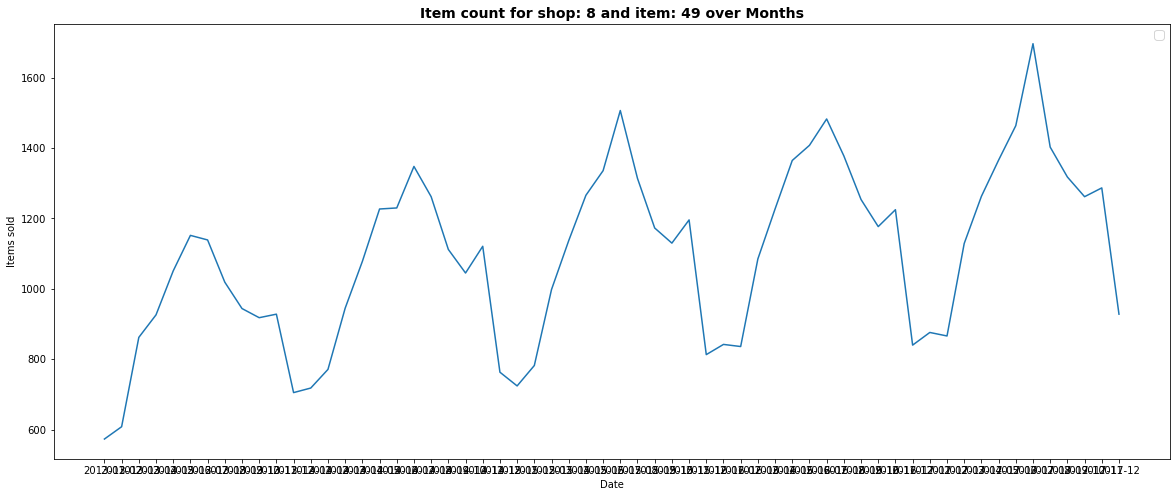

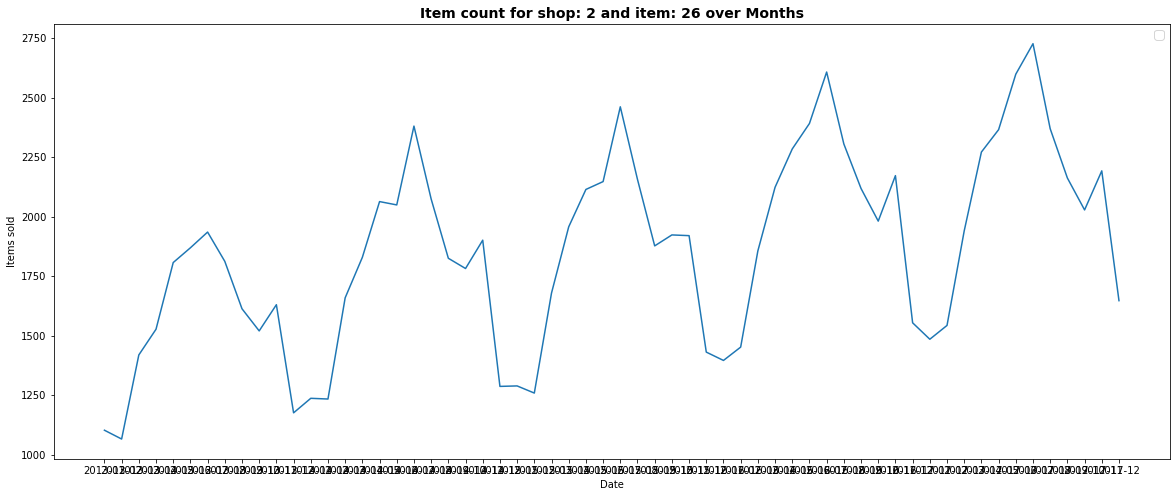

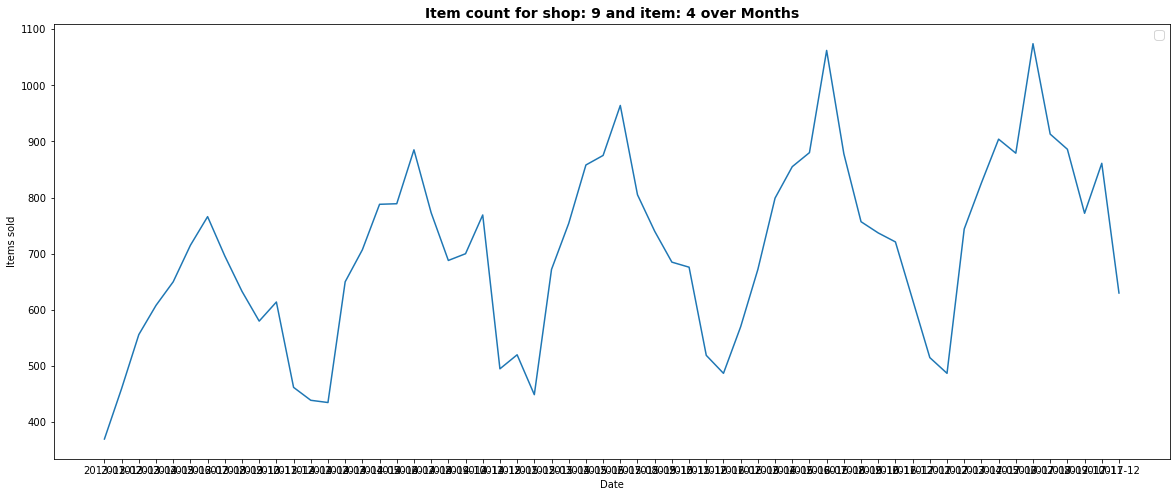

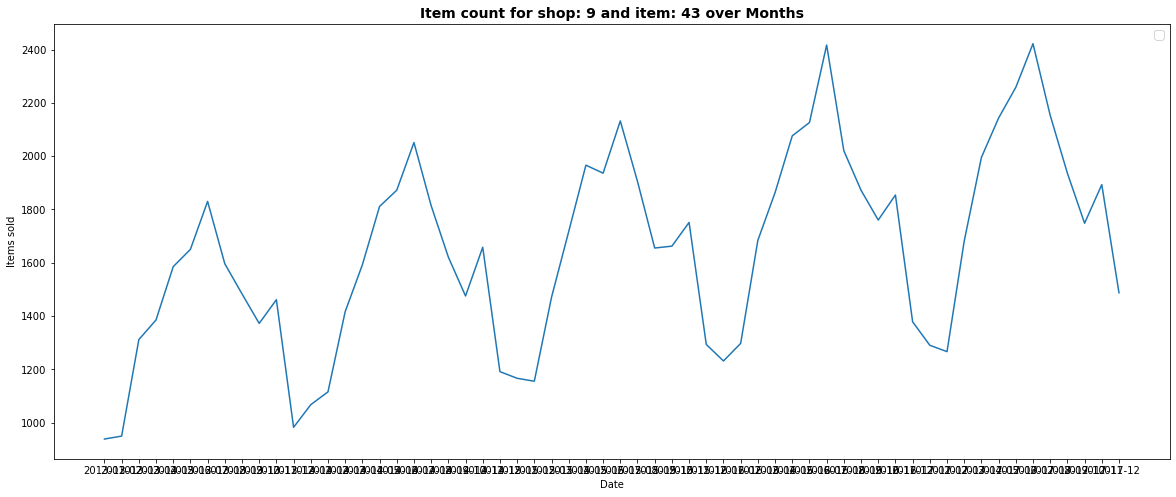

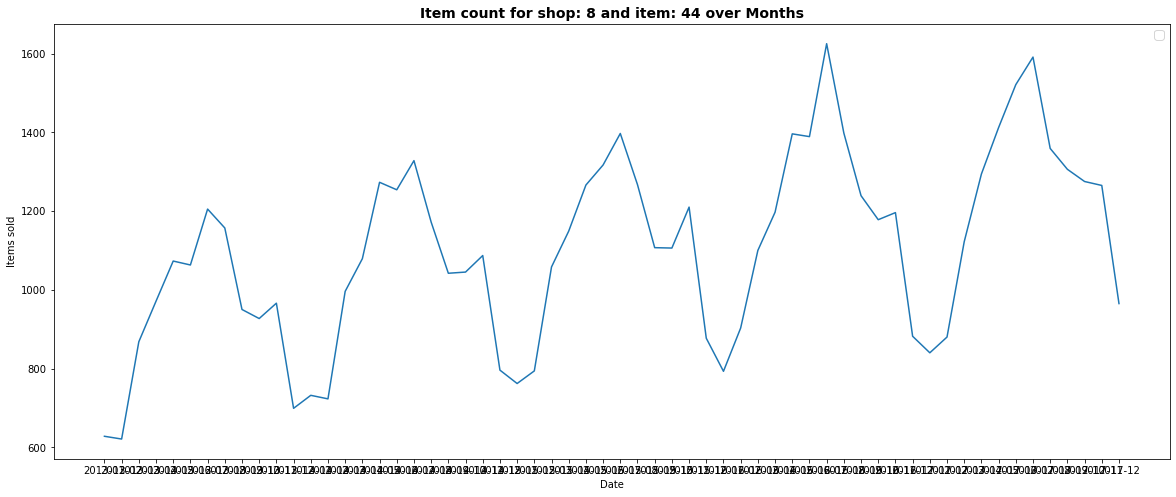

In [11]:
import matplotlib.pyplot as plt
from random import randint


def plot_sales(store_num, item_num):
    plt.figure(figsize = (20, 8))
    plt.plot(df.loc[(df["store"] == store_num) & 
                    (df["item"]==item_num),"year_month"], 
             df.loc[(df["store"] == store_num) & 
                    (df["item"]==item_num),"sales"])
    # başlık, etiketler ve eksenlerin stillerini güncelleme
    plt.title(f"Item count for shop: {store_num} and item: {item_num} over Months", 
              fontsize = 14, fontweight = "bold")
    plt.ylabel("Items sold")
    plt.xlabel("Date")
    plt.legend(fontsize = "large")
    plt.show()
for i in range(1,6):
    store_num = randint(1,10)
    item_num = randint(1,50)
    plot_sales(store_num,item_num)

#randomly chosen stores and items shows that, items sold at each store 
#follows seasonality and trend. Methods such as Single/Double Exp. Smoothing
#and ARIMA could not be able to perform well.

In [12]:
#Triple Exp. Smoothing
#We divide train set into train and test set, Our period is 12 and train 
#set for each item and store will be the dates between 01-2013 and 12-2016
#validation set will be between 01-2017 and 12-2017
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
import itertools
import numpy as np
import warnings
warnings.filterwarnings('ignore')
alphas = betas = gammas = np.arange(0.20, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
#the function we use for hyperparameter optimization will be as follows
def tes_optimizer(train, test, abg, step=12):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], \
                smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], \
            comb[2], mae
    return best_alpha, best_beta, best_gamma, best_mae

df_train = df.loc[(df["store"]==1) & (df["item"]==1),
                         "sales"][:47]
df_val = df.loc[(df["store"]==1) & (df["item"]==1),
                         "sales"][48:]

best_alpha, best_beta, best_gamma, best_mae = \
tes_optimizer(df_train, df_val, abg)

best_alpha, best_beta, best_gamma, best_mae

(0.30000000000000004,
 0.6000000000000001,
 0.5000000000000001,
 48.21752702987243)

In [13]:
#SARIMA MODEL
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def sarima_optimizer_mae(train, test, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=12)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
            except:
                continue    
    return best_order, best_seasonal_order, best_mae

best_order, best_seasonal_order, best_mae_sarima = sarima_optimizer_mae(df_train, df_val, 
                                                       pdq, seasonal_pdq)

best_order, best_seasonal_order, best_mae_sarima

((0, 0, 0), (1, 0, 1, 12), 44.45027303019183)

In [14]:
#LIGHT GBM 
#Apart from other forecasting methods, in Light GBM we will derive new features for our model
#First we construct a function to derive new date features

df["month"] = df["year_month"].str[5:]
df["year"] = df["year_month"].str[:4].astype(int)

#We will add lag features for sales variable (3 months, 6 months, 12 months)
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag))
    return dataframe
df = lag_features(df, [3, 6, 12])
#We will add rolling mean features for sales variable (3 months, 6 months, 12 months, 15 months)
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=2, win_type="triang").mean())
    return dataframe
df = roll_mean_features(df, [3, 6, 12, 15])

#Finally, we will add exponentially weighted mean features (3 months, 6 months, 12 months, 15 months)
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [3, 6, 9, 12, 15]
df = ewm_features(df, alphas, lags)

In [15]:
df = pd.get_dummies(df, columns=['store', 'item', 'month']) #One-hot encoding
df['sales'] = np.log1p(df["sales"].values) #taking the logarithm of dependent variable to inrease computational efficiency

train_lgbm = df.loc[df["year"].astype(int)<2017]
val_lgbm = df.loc[df["year"].astype(int)==2017]

cols = [col for col in train_lgbm.columns if col not in ["id", "sales", "year_month", "year"]]

X_train = train_lgbm[cols]
Y_train = train_lgbm["sales"]

X_val = val_lgbm[cols]
Y_val = val_lgbm["sales"]

In [16]:
import lightgbm as lgb
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],                  
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

mae = mean_absolute_error(Y_val, y_pred_val)
print(f"Mean Absolute Error Value for Light GBM model = {mae}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006705 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0244417	valid_1's l2: 0.0115572
[200]	training's l2: 0.012768	valid_1's l2: 0.00448592
[300]	training's l2: 0.0095454	valid_1's l2: 0.00353046
[400]	training's l2: 0.00705962	valid_1's l2: 0.00314786
[500]	training's l2: 0.00552245	valid_1's l2: 0.00302954
[600]	training's l2: 0.00460954	valid_1's l2: 0.00290976
[700]	training's l2: 0.0039717	valid_1's l2: 0.00282894
[800]	training's l2: 0.00347999	valid_1's l2: 0.00275685
[900]	training's l2: 0.0031264	valid_1's l2: 0.00269411
[1000]	training's l2: 0.00288346	valid_1's l2: 0.00262966
Did not meet early stopping. Best iteration is:
[1000]	training's l2: 0.00288346	valid_1's l2: 0.00262966
Mean Absolute Error Value for Light GBM model = 0.04121632010073385


In [17]:
#Light GBM seems to give the best results. 
#Concat train and test dataset
train.drop("year_month", inplace=True, axis=1)
final_df = pd.concat([train,test], sort=False)
final_df.tail()

,date,store,item,sales,id
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0
44999,2018-03-31,10,50,NaN,44999.0


In [18]:
#Feature engineering
#define new features from date variable
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df
final_df = create_date_features(final_df)

#lag features
#first we add random noise to our dataset
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

#then we define lag features function with added noise
def lag_features_v2(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

final_df = lag_features_v2(final_df, [91, 98, 105, 112, 119, 126, 182, 364, 546])

#rolling mean features (with random noise)
def roll_mean_features_v2(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

final_df = roll_mean_features_v2(final_df, [365, 546])

#Exp. weighted mean features
def ewm_features_v2(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]
final_df = ewm_features_v2(final_df, alphas, lags)

final_df = pd.get_dummies(final_df, columns=['store', 'item', 'day_of_week', 'month'])

#log conversion of sales 
final_df['sales'] = np.log1p(final_df["sales"].values)
final_df.head()  #final model has 144 features including Sales variable

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,NaN,1,1,1,2013,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,2.484907,NaN,2,2,1,2013,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,2.708050,NaN,3,3,1,2013,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,2.639057,NaN,4,4,1,2013,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,2.397895,NaN,5,5,1,2013,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
#Creating model
#defining custom cost function
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

# We will predict first 3 months of 2018. Thus, we will construct our model for first 3 months of 2017. 
#Train set will include days before 2017-01-01
train = final_df.loc[(final_df["date"] < "2017-01-01"), :]

#Validation set will include first three months of 2017
val = final_df.loc[(final_df["date"] >= "2017-01-01") & (final_df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.385312 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0512991	training's SMAPE: 17.5798	valid_1's l2: 0.0535284	valid_1's SMAPE: 17.5223
[200]	training's l2: 0.0351764	training's SMAPE: 14.5531	valid_1's l2: 0.0368935	valid_1's SMAPE: 14.8606
[300]	training's l2: 0.0323894	training's SMAPE: 13.9976	valid_1's l2: 0.0340109	valid_1's SMAPE: 14.405
[400]	training's l2: 0.031331	training's SMAPE: 13.7847	valid_1's l2: 0.0331787	valid_1's SMAPE: 14.2583
[500]	training's l2: 0.0306768	training's SMAPE: 13.6577	valid_1's l2: 0.0326218	valid_1's SMAPE: 14.1386
[600]	training's l2: 0.0302297	training's SMAPE: 13.5657	valid_1's l2: 0.0321817	valid_1's SMAPE: 14.0322
[700]	training's l2: 0.0299039	training's SMAPE: 13.4983	valid_1's l2: 0.0318672	valid_1's SMAPE: 13.9578
[800]	training's l2: 0.0296139	tr

13.82121614689291

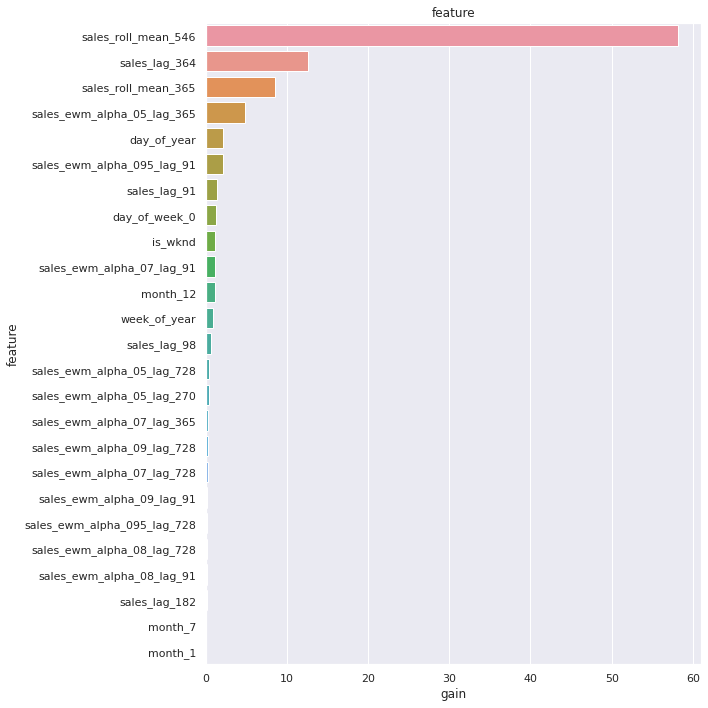

,feature,split,gain
16,sales_roll_mean_546,948,58.118507
13,sales_lag_364,1246,12.592872
15,sales_roll_mean_365,647,8.580250
59,sales_ewm_alpha_05_lag_365,359,4.832150
1,day_of_year,748,2.204225
...,...,...,...
106,item_35,0,0.000000
73,item_2,0,0.000000
110,item_39,0,0.000000
114,item_43,0,0.000000


In [20]:
#draw importance plot
import seaborn as sns
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=30, plot=True)

In [21]:
#creating final model
train = final_df.loc[~final_df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = final_df.loc[final_df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.459343 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [22]:
#creating submission file
submission_df = test.loc[:, ["id", "sales"]]
submission_df['sales'] = np.expm1(test_preds)

submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv("submission_demand.csv", index=False)